In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


# sys.path.append("/path/to/your/project")
from hockey.hockey_env import HockeyEnv_BasicOpponent, Mode

#try:
#    from models.ddpg.DDPG import DDPGAgent
#    from models.ddpg.DDPGTrainer import DDPGTrainer

try:
    from models.dreamer.DREAM import DreamerV3Agent
    from models.dreamer.DREAMTrainer import DreamerV3Trainer
except ImportError:
    print("Could not import DDPG.")
    raise

In [2]:
# The single-agent wrapper environment is `HockeyEnv_BasicOpponent`.
# By default:
#   - It uses mode=Mode.NORMAL
#   - keep_mode=True
#   - An opponent with `weak_opponent=False` or True
#
# action_space of shape (4,) 
# suitable for a single-agent continuous control algorithms

env = HockeyEnv_BasicOpponent(
    mode=Mode.NORMAL,   # or Mode.TRAIN_SHOOTING, Mode.TRAIN_DEFENSE
    weak_opponent=True # whether the opponent is weaker or not
)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# For reference:
# - The observation space is Box(...) with shape (18,) if keep_mode=True.
# - The action space is Box(...) with shape (4,). 
#   The four actions: 
#       1) Force in x, 
#       2) Force in y, 
#       3) Torque (racket rotation),
#       4) Shoot command (0 or 1).

Observation space: Box(-inf, inf, (18,), float32)
Action space: Box(-1.0, 1.0, (4,), float32)


In [18]:
training_config = {
    "init_epsilon": 1.0,   
    "min_epsilon": 0.05,  
    "decay_epsilon": 0.999,  
    "total_episodes": 10000,     
    "episode_steps": 250,    
    "log_frequency": 20,
    "checkpoint_interval": 1000,
    "enable_render": False,         
    "training_iterations": 32,       
    "random_seed": 42, 
    "max_episodes":500,
      "log_interval": 20,
      "max_episodes": 500,
      "max_timesteps": 250,
      "render": False,
      "save_interval": 500,
      "seed": 42,
      "train_iter": 32
}


model_config = {
    "exploration_rate": 0.0,                   
    "gamma_discount": 0.95,      
    "replay_buffer_size": int(1e6),     
    "minibatch_size": 128,            
    "actor_lr": 1e-4, 
    "critic_lr": 1e-4,
    "actor_network_layers": [256, 256],
    "critic_network_layers": [256, 256],
    "target_update_freq": 100,
    "enable_target_network": True
}


experiment_path = "rl_experiments/experiments/HockeyEnv_Dreamer_20250215_214419"

# Initialize trainer
trainer = DreamerV3Trainer(
    env_name="HockeyEnv",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None 
)


2025-02-16 19:12:25 [INFO] Logger initialized. Writing logs to rl_experiments/experiments/HockeyEnv_Dreamer_20250215_214419/results/training/logs/dreamer_training.log
2025-02-16 19:12:25 [INFO] Initialized random seeds to 42.


In [4]:
checkpoint_path = "competition/DreamerTest/dreamer_checkpoint_ep500.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# 4) Restore the agent's networks
trainer.agent.restore_state(checkpoint)

/tmp/ipykernel_1584904/2740634367.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


In [6]:
num_test_episodes = 100
cumulative_rewards = []
win_count = 0
for ep in range(num_test_episodes):
    obs, _ = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # set simple deterministic policy
        #action = trainer.agent.act(obs, evaluate=True)  
        action = trainer.agent.act(obs)#, evaluate=True)  
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        env.render(mode="rgb_array")

        if done or trunc:
            break
    cumulative_rewards.append(episode_reward)
    win_count += info["winner"] 

env.close()

print("Average cumulative reward:", np.mean(cumulative_rewards))
print("Win rate:", win_count / num_test_episodes)



Average cumulative reward: -12.697595908365747
Win rate: -0.3


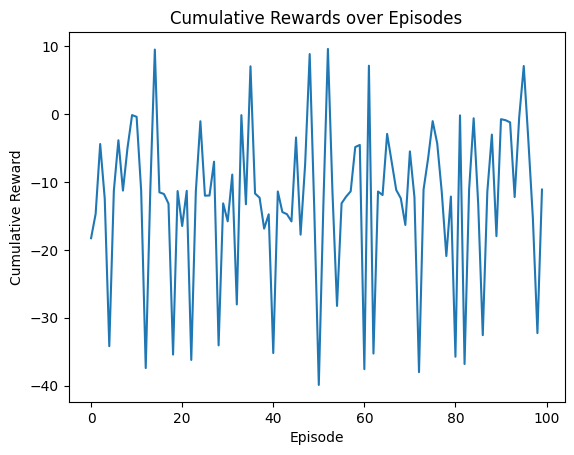

In [7]:
# plot the cumulative rewards
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over Episodes")
plt.show()


In [11]:
import imageio
import numpy as np

num_test_episodes = 50

for ep in range(num_test_episodes):
    frames = []
    obs, info = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # Act with no noise at test time
        action = trainer.agent.act(obs)#, evaluate=True)
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        # ---- Capture frame in rgb_array mode ----
        frame_rgb = env.render(mode='rgb_array')  
        frames.append(frame_rgb)

        if done or trunc:
            break

    env.close()
    print(f"Episode reward: {episode_reward}")

    # 4) Save frames as GIF
    gif_path = f"gifs/dream_laserhockey_episode{ep}.gif"
    imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
    print(f"Saved GIF to {gif_path}")

Episode reward: -19.85912781901654
Saved GIF to gifs/dream_laserhockey_episode0.gif
Episode reward: -11.249379476789972
Saved GIF to gifs/dream_laserhockey_episode1.gif
Episode reward: -12.710375104318466
Saved GIF to gifs/dream_laserhockey_episode2.gif
Episode reward: -6.78705074184708
Saved GIF to gifs/dream_laserhockey_episode3.gif
Episode reward: -36.71714500403235
Saved GIF to gifs/dream_laserhockey_episode4.gif
Episode reward: -11.21511664335298
Saved GIF to gifs/dream_laserhockey_episode5.gif
Episode reward: -2.8858795148339063
Saved GIF to gifs/dream_laserhockey_episode6.gif
Episode reward: 9.84429294692196
Saved GIF to gifs/dream_laserhockey_episode7.gif
Episode reward: -13.978444052829728
Saved GIF to gifs/dream_laserhockey_episode8.gif
Episode reward: -16.76434919518458
Saved GIF to gifs/dream_laserhockey_episode9.gif
Episode reward: -1.1481828088353268
Saved GIF to gifs/dream_laserhockey_episode10.gif
Episode reward: 6.936497715149956
Saved GIF to gifs/dream_laserhockey_epi

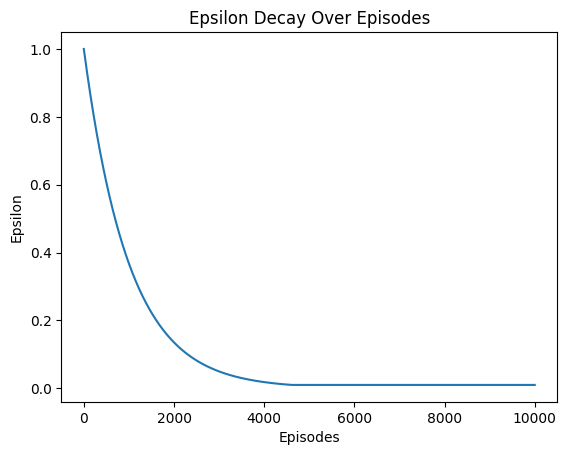

In [12]:
epsilon_start = 1.0  
epsilon_end = 0.01  
epsilon_decay = 0.999
max_episodes=10000
max_steps=500
episodes = np.arange(max_episodes)
epsilon_values = epsilon_start * (epsilon_decay ** episodes)
epsilon_values = np.maximum(epsilon_values, epsilon_end)

plt.plot(episodes, epsilon_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.show()

In [14]:

# 4) Save frames as GIF
gif_path = "dream_laserhockey_episode.gif"
imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
print(f"Saved GIF to {gif_path}")

Saved GIF to dream_laserhockey_episode.gif


## Further Training on Strong Opponent

In [19]:
## This is only experimental, not sure if the hypothesis is valid

final_metrics = trainer.train()

print("Training finished.")
print("Final metrics:", final_metrics)

2025-02-16 19:12:32 [INFO] Starting DreamerV3 Training on HockeyEnv
2025-02-16 19:12:32 [INFO] max_episodes=500, max_timesteps=250, train_iter=32
2025-02-16 19:12:34 [INFO] Episode 20:	Avg Reward=-166.12	Avg Len=205.2


KeyboardInterrupt: 